In [1]:
import preprocessing


cleaned_data = preprocessing.data

cleaned_data.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ayenyeinsan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayenyeinsan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ayenyeinsan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,posts,type
0,know intj tool use interact peopl excus antiso...,I
1,rap music ehh opp yeah know valid well know fa...,I
2,prefer p hd low except wew lad video p mind go...,I
3,drink like wish could drink red wine give head...,I
4,space program ah bad deal me freelanc max seem...,I


type
I    76.0623
E    23.9377
Name: proportion, dtype: float64


<Axes: xlabel='type'>

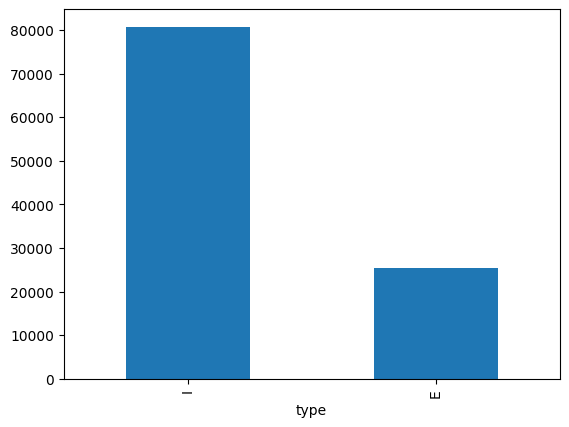

In [2]:
# Check class distribution in the full dataset
print(cleaned_data['type'].value_counts(normalize=True) * 100)
cleaned_data['type'].value_counts().plot(kind='bar')


In [3]:

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split


/Users/ayenyeinsan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ayenyeinsan/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    cleaned_data['posts'], cleaned_data['type'], test_size=0.2, random_state=42, stratify=cleaned_data['type']
)

In [9]:
import pandas as pd
# Convert train and test labels to Pandas Series for value counts
train_labels = pd.Series(train_labels)
test_labels = pd.Series(test_labels)

# Check class balance in train and test sets
print("Train set class distribution:\n", train_labels.value_counts(normalize=True) * 100)
print("\nTest set class distribution:\n", test_labels.value_counts(normalize=True) * 100)

Train set class distribution:
 type
0    76.062131
1    23.937869
Name: proportion, dtype: float64

Test set class distribution:
 type
0    76.062977
1    23.937023
Name: proportion, dtype: float64


In [6]:
#beacuse of the class imbalance more "I" in the train set and test set, we need to compute the class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert labels to numeric values (0 = I, 1 = E)
cleaned_data['type'] = cleaned_data['type'].map({'I': 0, 'E': 1})

# Compute class weights correctly
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=cleaned_data['type'])

# Convert to dictionary for model training
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class Weights:", class_weights_dict)

 

Class Weights: {0: np.float64(0.6573558759001946), 1: np.float64(2.0887554155179204)}


In [10]:
from transformers import AutoTokenizer

MODEL_NAME = "bert-base-uncased"  # Change to "roberta-base" for RoBERTa
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def tokenize_function(texts):
    return tokenizer(list(texts), truncation=True, padding="max_length", max_length=512)

# Tokenize training and test data
train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)


In [13]:
# Ensure labels are lists
train_labels = list(train_labels)
test_labels = list(test_labels)

from datasets import Dataset
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels  # Now correctly formatted
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels  # Now correctly formatted
})


model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=200,
    load_best_model_at_end=True
)

trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=None,  
    
)

trainer.train()


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [16]:
print(train_dataset.features)


{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}


In [17]:
import torch
from transformers import Trainer

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor([class_weights_dict[0], class_weights_dict[1]], dtype=torch.float)

# Define a custom Trainer to handle weighted loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels") 
        outputs = model(**inputs)

        # Ensure model outputs logits
        logits = outputs.logits if hasattr(outputs, "logits") else outputs

        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [18]:


# Use the custom trainer with class-weighted loss
trainer = WeightedTrainer(
    model=model, 
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
trainer.evaluate()


In [ ]:
#Preducting the personality type
def predict_mbti(text):
    inputs = tokenizer(text, truncation=True, padding=True, max_length=512, return_tensors="pt")
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits).item()
    return "Extrovert (E)" if prediction == 1 else "Introvert (I)"

# Example
new_post = "I love spending time alone reading books."
print(predict_mbti(new_post))
